# Analyze by loading all arrays for each sequence

In [101]:
import numpy as np
import numpy.linalg as la
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice
from  cmocean import cm

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [5]:
# get number of files
filenames = os.listdir("optim_res_return")

In [87]:
seq_key = ["saturn", "earth"]
seq_name = ""
for el in seq_key:
    seq_name += el + "-"
seq_name = seq_name[:-1]

seq_name + "_"

'saturn-earth_'

In [88]:
# get solar system
ssdict = pxp.solar_system_spice()

tof = [
    [2/pk.DAY2YEAR, 6/pk.DAY2YEAR] for el in range(len(seq_key)-1)
]

pop_list = []
prob_list = []

i_window = 0
t0_iter = [
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + i_window*30,
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + (i_window+1)*30

]
# run problem
seq = [ssdict[el] for el in seq_key]

prob_test = pxp.get_return_problem(seq, t0_iter, tof)

In [89]:
n_data_already = 0
for filename in filenames:
    if "seq_" + seq_name + "_" in filename:
        if n_data_already == 0:
            xload = np.load(
                os.path.join("optim_res_return", filename)
            )
        else:
            xload = np.concatenate(
                (xload, 
                    np.load(os.path.join("optim_res_return", filename))
                )
            )
        n_data_already += 1

n_data_already

3

In [90]:
ndat, _ = xload.shape
fload = []

for idx in range(ndat):
    fload.append(
        prob_test.fitness(xload[idx,:])
    )

In [91]:
ndat

12000

In [92]:
prob_test._add_vinf_arr

True

In [93]:
len(fload)

12000

In [94]:
porkchop_return = pxp.porkchop_process(
    prob_test, xload, fload, len(seq_key)-1, direction="return",
)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [95]:
porkchop_return.keys()

dict_keys(['t0', 't0_matplotlib', 'tf_matplotlib', 'tof_total', 'dsm_total', 'dv_total', 'launch_deltaV', 'arrival_deltaV', 'entry_v', 'f', 'x', 'idx'])

In [96]:
np.argmin(porkchop_return['tof_total'])

3168

In [97]:
shortest_idx = porkchop_return["idx"][np.argmin(porkchop_return['dv_total'])]
prob_test.pretty(xload[shortest_idx])

First Leg: 6, SUN, ECLIPJ2000 to 3, SUN, ECLIPJ2000
Departure: 2047-Dec-30 18:38:29.924575 (17530.776735238134 mjd2000) 
Duration: 2562.5020815129324days
VINF: 1.999999984769004 km/sec
DSM after 458.274613694491 days
DSM magnitude: 3244.044666250289m/s

Arrival at 3, SUN, ECLIPJ2000
Arrival epoch: 2055-Jan-05 06:41:29.767292 (20093.278816751066 mjd2000) 
Arrival Vinf: 10242.69627679327m/s
Total mission time: 7.01574834089783 years (2562.5020815129324 days)


<IPython.core.display.Javascript object>


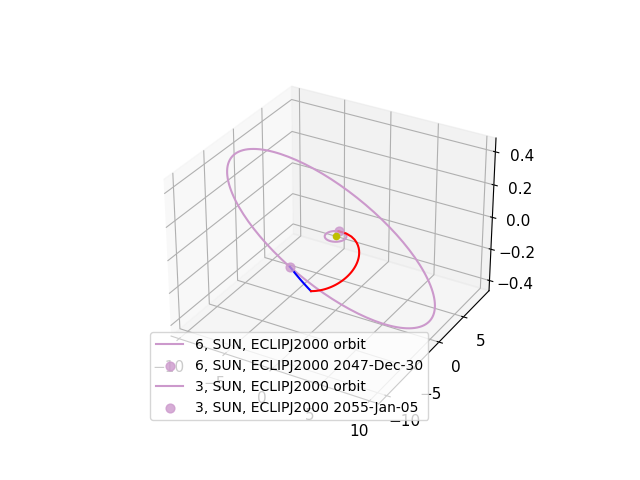

<Axes3DSubplot:>

In [98]:
prob_test.plot(xload[shortest_idx])

<IPython.core.display.Javascript object>


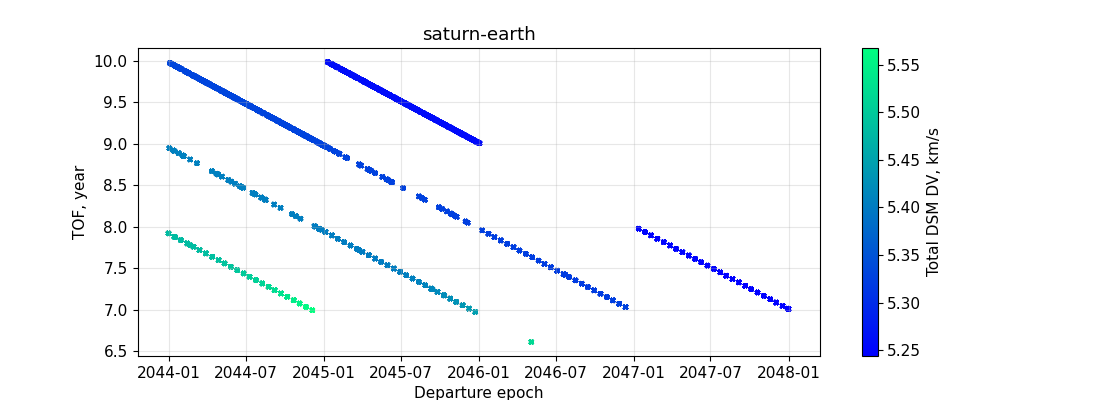

In [102]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(11,4))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['dsm_total']/1e3, cmap='winter', s=8, marker='x')

fig.colorbar(im0, label='Total DSM DV, km/s')
ax.set_title(seq_name)
ax.set(xlabel="Departure epoch", ylabel="TOF, year")
ax.grid(True, alpha=0.3)

plt.show()

<IPython.core.display.Javascript object>


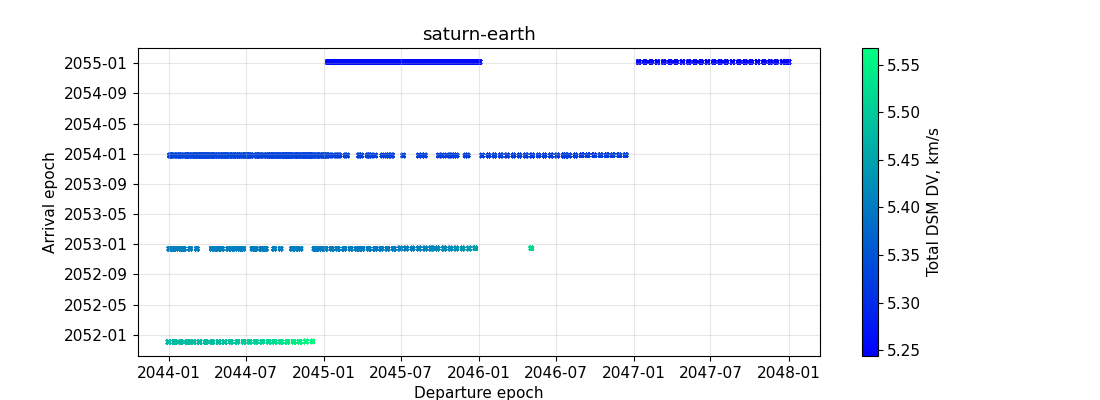

In [104]:
plt.rcParams["font.size"] = 11

fig2, ax = plt.subplots(1,1,figsize=(11,4))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tf_matplotlib'], 
                 c=porkchop_return['dsm_total']/1e3, cmap='winter', s=8, marker='x',
                 #vmin=5.0, vmax=6.0,
                )

fig2.colorbar(im0, label='Total DSM DV, km/s')
ax.set_title(seq_name)
ax.set(xlabel="Departure epoch", ylabel="Arrival epoch")
ax.grid(True, alpha=0.3)

plt.show()

In [105]:
plt.savefig("./plots/seq_"+seq_name+"_dsm_dv.png")

<IPython.core.display.Javascript object>


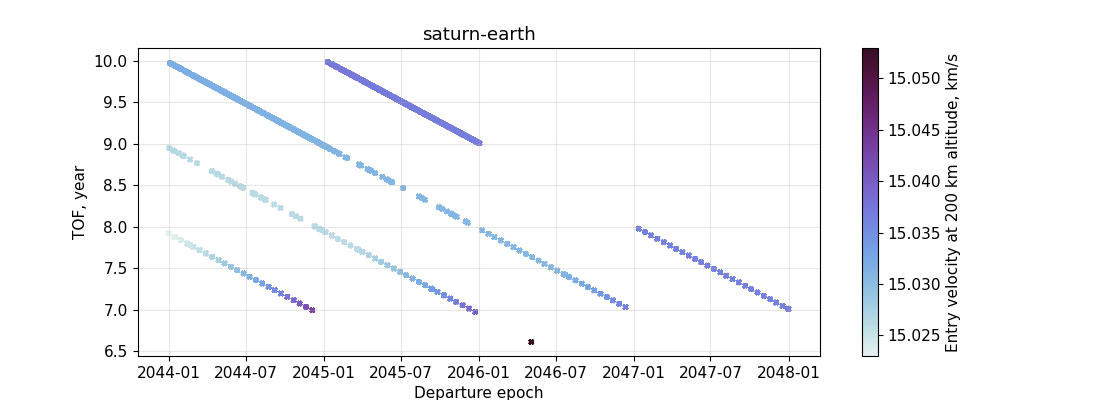

In [107]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(11,4))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['entry_v']/1e3, cmap=cm.dense, s=8, marker='x')

fig.colorbar(im0, label='Entry velocity at 200 km altitude, km/s')
ax.set_title(seq_name)
ax.set(xlabel="Departure epoch", ylabel="TOF, year")
ax.grid(True, alpha=0.3)

plt.show()

In [108]:
plt.savefig("./plots/seq_"+seq_name+"_ventry.png")

### Index of solution

In [ ]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(11,4))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['idx'], cmap='plasma', s=15, marker='x')

fig.colorbar(im0, label='Index')
ax.set_title(seq_name)
ax.set(xlabel="Departure epoch", ylabel="TOF, year")

plt.show()